# Initialization

## Imports

In [23]:
import numpy as np
import pandas as pd
from ml_tune_helpers.arima.stat_tests import StatTestWrapper
from ml_tune_helpers.arima.transformations import TransformHelper
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.api import SimpleExpSmoothing
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Constants

In [243]:
TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

CSV_JOINT_FILE = '../../datasources/ds_joint/ds.csv'

POL_CODES = [7, 6001, 5, 8]
POL_NAMES = {7: "O3", 6001: "PM25", 5: "PM10", 8: "NO2"}

WEATHER_USE_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']
AQI_USE_COLUMNS = ['AQI_O3', 'AQI_PM25', 'AQI_PM10', 'AQI_NO2', 'AQI']
CONC_MEAN_USE_COLUMNS = ['C_mean_O3', 'C_mean_PM25', 'C_mean_PM10', 'C_mean_NO2']

## Data load

In [244]:
df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')
df_weather = df_joint.loc[TRAIN_DATE_FROM:VAL_DATE_TO, WEATHER_USE_COLUMNS]
df_joint = df_joint.loc[TRAIN_DATE_FROM:VAL_DATE_TO, AQI_USE_COLUMNS]

In [245]:
df_weather.shape

(2958, 8)

In [246]:
df_weather.describe()

,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,pres
count,2945.000000,2945.000000,2945.000000,709.000000,2675.000000,2706.000000,1652.000000,2935.000000
mean,11.329304,7.749236,14.766553,2.477856,194.585794,16.086511,40.756416,1015.895060
std,5.930431,5.606548,6.788618,4.908983,90.802512,8.029113,19.179388,10.027877
min,-5.700000,-10.200000,-4.400000,0.000000,0.000000,2.100000,11.100000,976.000000
25%,6.800000,3.500000,9.500000,0.000000,133.000000,10.500000,29.000000,1010.000000
50%,11.100000,7.700000,14.500000,0.000000,212.000000,14.600000,36.000000,1016.700000
75%,16.200000,12.200000,20.000000,2.600000,255.000000,20.300000,50.000000,1022.400000
max,28.600000,21.700000,37.200000,35.700000,359.000000,155.400000,356.000000,1046.900000


In [247]:
df_weather.isna().sum()

tavg      13
tmin      13
tmax      13
prcp    2249
wdir     283
wspd     252
wpgt    1306
pres      23
dtype: int64

In [248]:
df_weather['prcp'].fillna(0, inplace=True)
df_weather['wpgt'].fillna(0, inplace=True)
df_weather['tavg'].fillna(df_weather['tavg'].interpolate(option='time'), inplace=True)
df_weather['tmin'].fillna(df_weather['tmin'].interpolate(option='time'), inplace=True)
df_weather['tmax'].fillna(df_weather['tmax'].interpolate(option='time'), inplace=True)
df_weather['wdir'].fillna(df_weather['wdir'].interpolate(option='time'), inplace=True)
df_weather['wspd'].fillna(df_weather['wspd'].interpolate(option='time'), inplace=True)
df_weather['pres'].fillna(df_weather['pres'].interpolate(option='time'), inplace=True)
df_weather.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
wpgt    0
pres    0
dtype: int64

In [249]:
df_weather.describe()

,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,pres
count,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000,2958.000000
mean,11.317191,7.734719,14.757150,0.593915,194.027890,15.930849,22.761866,1015.898529
std,5.925079,5.604018,6.781022,2.624716,88.978251,7.800811,24.801440,10.004716
min,-5.700000,-10.200000,-4.400000,0.000000,0.000000,2.100000,0.000000,976.000000
25%,6.800000,3.500000,9.500000,0.000000,134.750000,10.700000,0.000000,1010.025000
50%,11.000000,7.700000,14.400000,0.000000,210.000000,14.400000,25.000000,1016.700000
75%,16.200000,12.200000,20.000000,0.000000,253.000000,19.737500,40.000000,1022.375000
max,28.600000,21.700000,37.200000,35.700000,359.000000,155.400000,356.000000,1046.900000


# Statistical analysis

## Stationary

In [250]:
df = df_joint['AQI_O3'].to_frame()
column_name = 'AQI_O3'

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - без дифференцирования
The ADF test statistic -4.897069    pvalue: 0.00   maximal Lag: 28   critical values: {'1%': -3.4325845647747215, '5%': -2.8625272824212167, '10%': -2.5672955578799543}
ADF: stationary
The KPSS test statistic 0.147351    pvalue: 0.10   maximal Lag: 27   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


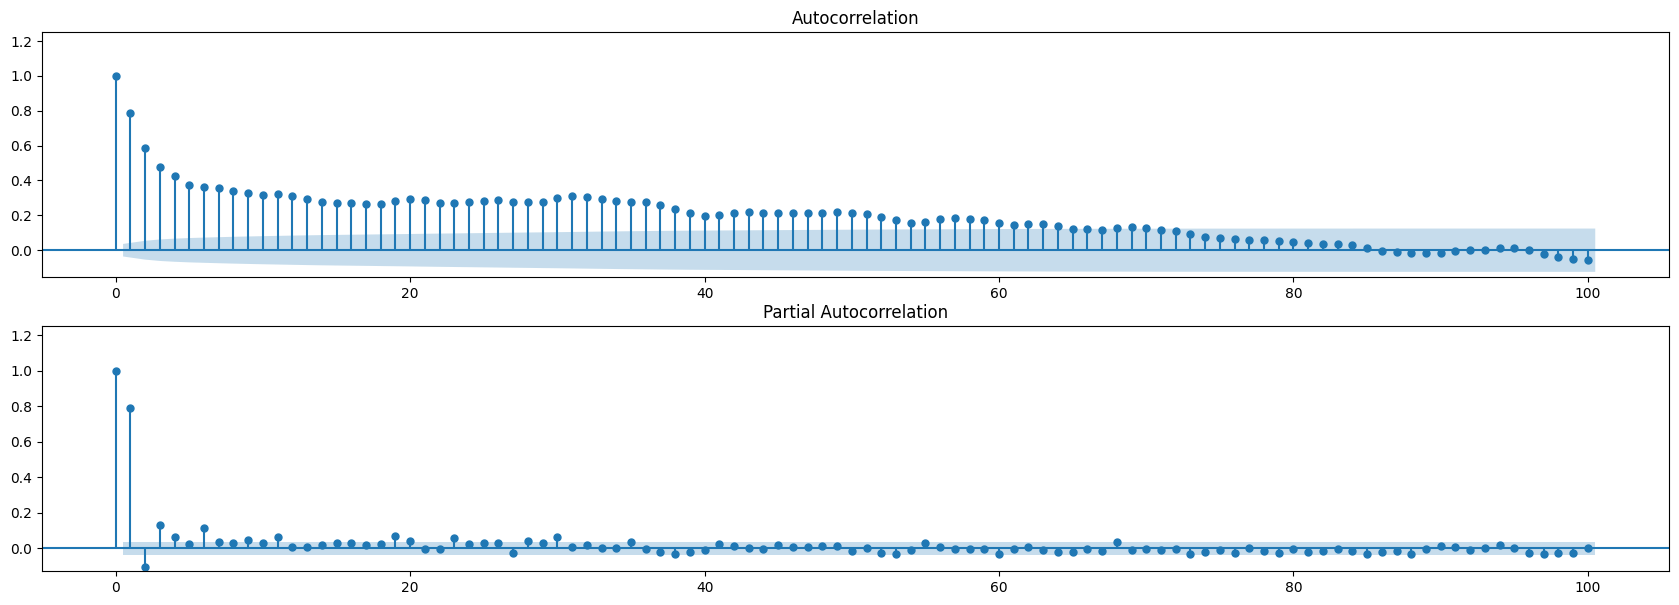

In [251]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - без дифференцирования')
df_diff = StatTestWrapper.pre_analise(df, column_name=column_name, lags=100)

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году
The ADF test statistic -11.682459    pvalue: 0.00   maximal Lag: 18   critical values: {'1%': -3.432893058802077, '5%': -2.862663524069147, '10%': -2.5673680929672074}
ADF: stationary
The KPSS test statistic 0.073477    pvalue: 0.10   maximal Lag: 22   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


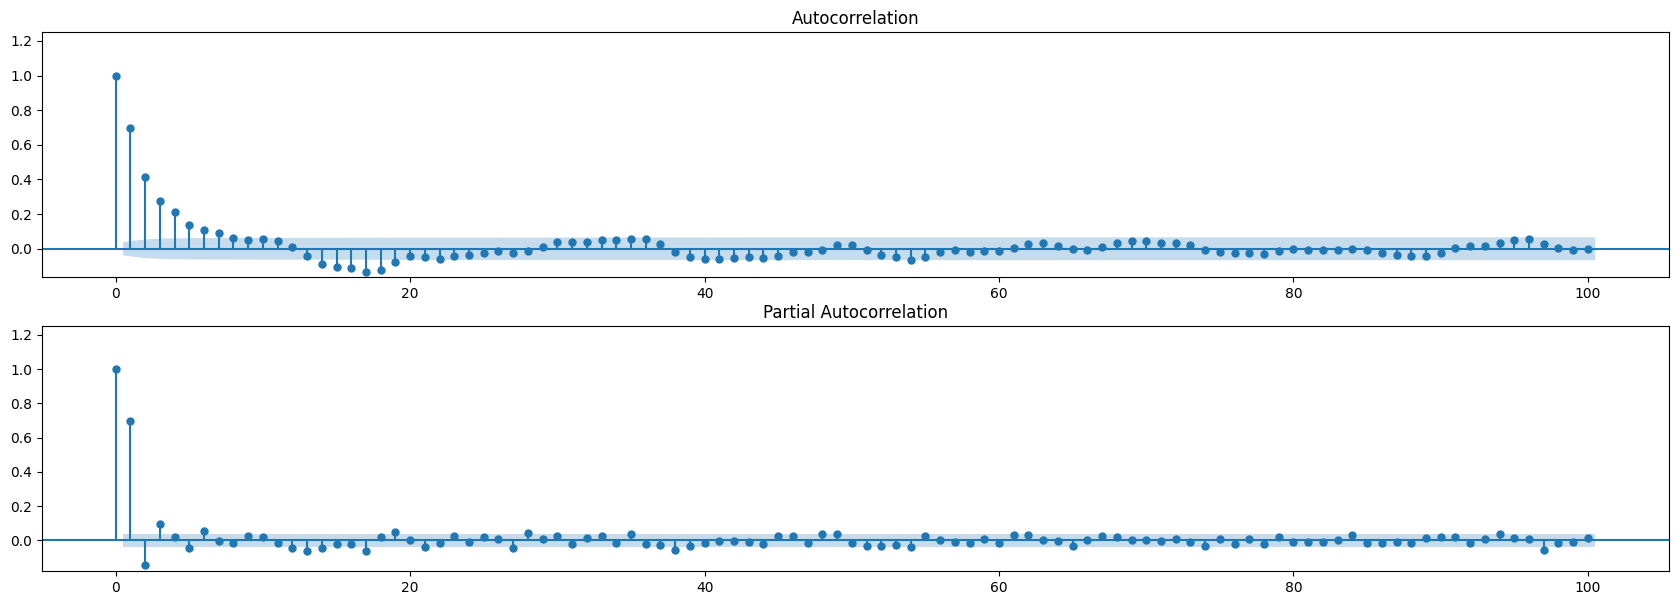

In [252]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году')
df_diff = StatTestWrapper.pre_analise(df, column_name=column_name, diffs_needed=[('Y', 1)], lags=100)

## Trend/seasonality decomposition

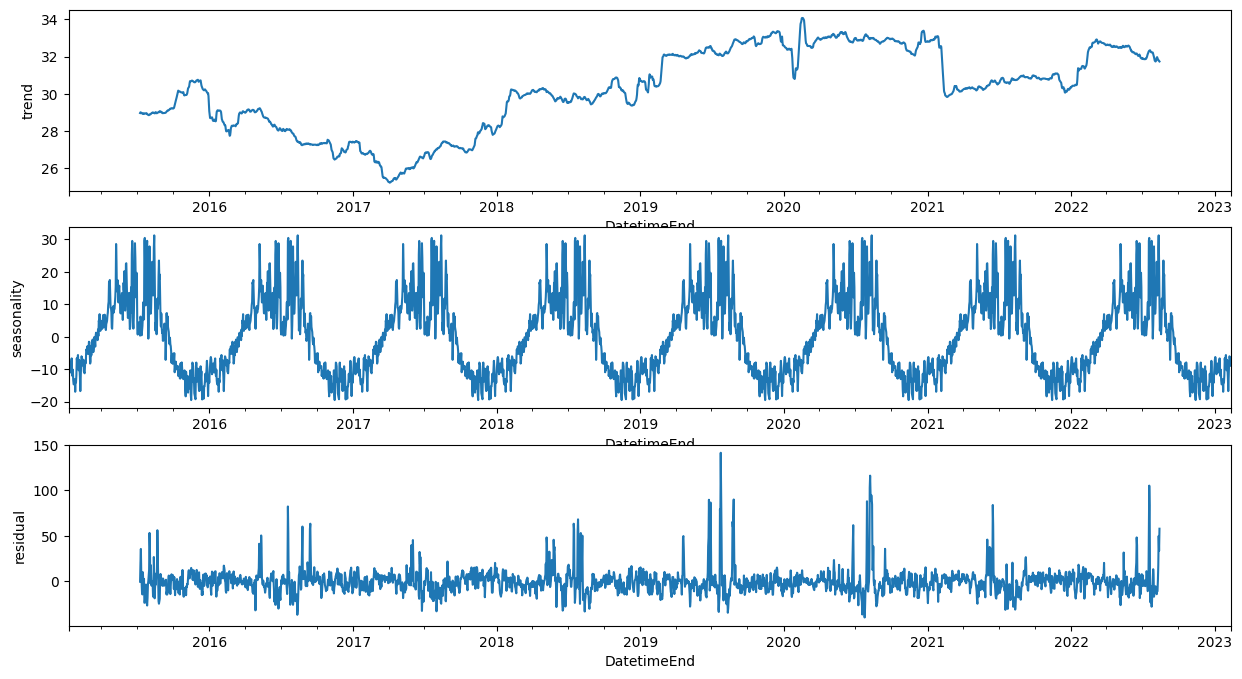

In [253]:
res = seasonal_decompose(df, model = "additive",period = 365)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.seasonal.plot(ax=ax2,ylabel = "seasonality")
res.resid.plot(ax=ax3,ylabel = "residual")
plt.show()

# SARIMAX

## Auto arima - D and d

In [254]:
print('Подбор дифференцирования по тренду с помощью модуля pmdarima:')
print(f'Adf test, d: {ndiffs(df, test="adf")}')
print(f'KPSS test, d: {ndiffs(df, test="kpss")}')

Подбор дифференцирования по тренду с помощью модуля pmdarima:
Adf test, d: 0
KPSS test, d: 0


In [255]:
print('Подбор дифференцирования по сезону с помощью модуля pmdarima:')
print(f'Canova-Hansen test, m=365, D: {nsdiffs(df, m=365, max_D=1, test="ch")}')
print(f'OCSB test, m=365, D: {nsdiffs(df, m=365, max_D=7, test="ocsb")}')
print(f'Canova-Hansen test, m=30, D: {nsdiffs(df, m=30, max_D=6, test="ch")}')
print(f'OCSB test, m=30, D: {nsdiffs(df, m=30, max_D=6, test="ocsb")}')
print(f'Canova-Hansen test, m=7, D: {nsdiffs(df, m=7, max_D=5, test="ch")}')
print(f'OCSB test, m=7, D: {nsdiffs(df, m=7, max_D=5, test="ocsb")}')

Подбор дифференцирования по сезону с помощью модуля pmdarima:
Canova-Hansen test, m=365, D: 1
OCSB test, m=365, D: 0
Canova-Hansen test, m=30, D: 0
OCSB test, m=30, D: 0
Canova-Hansen test, m=7, D: 0
OCSB test, m=7, D: 0


## Auto arima - (pdq)(PDQ)[m]

In [256]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     start_P=0, start_Q=0,
                     max_p=7, max_q=7,
                     seasonal=True,
                     d=1, m=12, trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
# ARIMA(6,1,1)(0,0,0)[12] AIC = 22739.704,

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=23170.670, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=23172.875, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=23172.463, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=23168.670, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=23171.356, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=23171.369, Time=0.21 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=23172.505, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=23172.225, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=23171.830, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=22790.763, Time=0.24 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=22791.294, Time=0.67 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=22791.321, Time=0.81 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=22791.088, Time=2.80 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=22703.902, Time=0.41 sec
 ARIM

In [17]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     start_P=0, start_Q=0,
                     max_p=7, max_q=7,
                     seasonal=True,
                     d=1, D=1, m=12, trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
# ARIMA(0,1,3)(2,1,0)[12] AIC=23536.793

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=25114.608, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=24304.117, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=25114.842, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=23936.576, Time=0.69 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=23935.874, Time=0.82 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=24302.533, Time=0.22 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=8.53 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=23935.508, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=24303.774, Time=0.34 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=9.50 sec
 ARIMA(0,1,1)(1,1,1)[12]             : A

In [87]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     start_P=0, start_Q=0,
                     max_p=7, max_q=7,
                     seasonal=True,
                     #stationary=True,
                     D=1, m=12,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
# ARIMA(4,0,0)(1,0,1)[12] AIC=22804.044  -crazy z-stat
# ARIMA(0,0,1)(0,1,1)[12] AIC=23759.044

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=26640.731, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=23845.143, Time=0.98 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=23761.836, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=26638.731, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=25107.612, Time=0.27 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=23763.358, Time=4.31 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=24301.938, Time=0.88 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=23765.768, Time=7.30 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=25437.719, Time=0.78 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.17 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=4.73 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.93 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=6.95 sec
 ARIMA(0,0,1)(0,1,1)[12]           

In [19]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     max_p=7, max_q=7,
                     seasonal=False,
                     stationary=True,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
# ARIMA(2,0,2)(0,0,0)[0] AIC=22741.508

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25803.833, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22905.169, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=23879.710, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29564.170, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=22875.582, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=22824.887, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=22814.374, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=22814.880, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=22754.372, Time=1.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=22748.871, Time=1.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=22856.837, Time=0.48 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=22743.539, Time=1.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=22741.508, Time=0.92 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=22834.266, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0

<bound method ARIMA.aic of ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)>

In [20]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     max_p=7, max_q=7,
                     seasonal=False,
                     d=1,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
# ARIMA(6,1,1)(0,0,0)[0] AIC=22737.704

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23223.588, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23225.108, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23224.683, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23221.588, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22842.256, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22755.524, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23063.370, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22747.946, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23006.555, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=22749.934, Time=0.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=22749.940, Time=1.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22749.866, Time=0.52 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=22985.988, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=22747.819, Time=1.06 sec
 ARIMA(5,1,2)(0,0,0

<bound method ARIMA.aic of ARIMA(order=(6, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>

## SARIMAX different model tests

In [265]:
df_train = df.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
df_val = df.loc[VAL_DATE_FROM:VAL_DATE_TO,]

In [266]:
model_trend_no_season = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1)).fit(disp=0)
model_trend_no_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 AQI_O3   No. Observations:                 2951
Model:               SARIMAX(6, 1, 1)   Log Likelihood              -11310.404
Date:                Thu, 02 Mar 2023   AIC                          22636.808
Time:                        18:39:59   BIC                          22684.724
Sample:                    01-08-2015   HQIC                         22654.058
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8111      0.013     61.116      0.000       0.785       0.837
ar.L2         -0.2196      0.011    -20.392      0.000      -0.241      -0.198
ar.L3          0.0477      0.015      3.275      0.001       0.019       0.076
ar.L4          0.0465      0.016      2.848      0.004       0.015       0.079
ar.L5         -0.0850      0.017     -4.870      0.000      -0.119      -0.051
ar.L6          0.0597      0.014      4.414      0.000       0.033       0.086
ma.L1         -0.9536      0.009   -103.377      0.000      -0.972      -0.936
sigma2       125.1877      1.075    116.496      0.000     123.081     127.294
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             57633.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             2.50
Prob(H) (two-sided):                  0.03   Kurtosis:                        24.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [267]:
model_no_trend_season = sm.tsa.statespace.SARIMAX(df_train, order=(2,0,2), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False).fit(disp=0)
model_no_trend_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               AQI_O3   No. Observations:                 2951
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood              -11245.068
Date:                              Thu, 02 Mar 2023   AIC                          22502.136
Time:                                      18:40:09   BIC                          22538.021
Sample:                                  01-08-2015   HQIC                         22515.061
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5132      0.017     89.063      0.000       1.480       1.546
ar.L2         -0.5197      0.016    -33.239      0.000      -0.550      -0.489
ma.L1         -0.6673      0.018    -36.750      0.000      -0.703      -0.632
ma.L2         -0.2501      0.011    -23.443      0.000      -0.271      -0.229
ma.S.L12      -0.9903      0.005   -183.951      0.000      -1.001      -0.980
sigma2       126.1549      1.174    107.480      0.000     123.854     128.455
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             60656.04
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             2.66
Prob(H) (two-sided):                  0.02   Kurtosis:                        24.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [268]:
model_trend_season = sm.tsa.statespace.SARIMAX(df_train, order=(0,1,3), seasonal_order=(2, 1, 0, 12)).fit(disp=0)
model_trend_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              AQI_O3   No. Observations:                 2951
Model:             SARIMAX(0, 1, 3)x(2, 1, [], 12)   Log Likelihood              -11708.269
Date:                             Thu, 02 Mar 2023   AIC                          23428.538
Time:                                     18:40:18   BIC                          23464.451
Sample:                                 01-08-2015   HQIC                         23441.469
                                      - 02-05-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1595      0.010    -15.540      0.000      -0.180      -0.139
ma.L2         -0.3933      0.010    -37.652      0.000      -0.414      -0.373
ma.L3         -0.2809      0.012    -22.956      0.000      -0.305      -0.257
ar.S.L12      -0.6854      0.010    -71.594      0.000      -0.704      -0.667
ar.S.L24      -0.3536      0.009    -38.305      0.000      -0.372      -0.336
sigma2       168.9306      1.745     96.808      0.000     165.510     172.351
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):             23017.98
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             1.50
Prob(H) (two-sided):                  0.04   Kurtosis:                        16.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
model_no_trend_no_season = sm.tsa.statespace.SARIMAX(df_train, order=(2,0,2)).fit(disp=0)
model_no_trend_no_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 AQI_O3   No. Observations:                 2951
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -11322.370
Date:                Thu, 02 Mar 2023   AIC                          22654.741
Time:                        18:40:23   BIC                          22684.690
Sample:                    01-08-2015   HQIC                         22665.522
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5348      0.014    111.989      0.000       1.508       1.562
ar.L2         -0.5355      0.014    -39.175      0.000      -0.562      -0.509
ma.L1         -0.6822      0.014    -48.193      0.000      -0.710      -0.654
ma.L2         -0.2519      0.010    -24.309      0.000      -0.272      -0.232
sigma2       125.7939      1.189    105.765      0.000     123.463     128.125
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             60818.18
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             2.57
Prob(H) (two-sided):                  0.03   Kurtosis:                        24.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fourier transformation for 2 (k=1) and 4 (k=2) series

In [270]:
exog_k1 = TransformHelper.apply_fourier(df)
exog_k2 = TransformHelper.apply_fourier(df, k_sins=2)

In [271]:
exog_k1_train = exog_k1.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
exog_k1_val =exog_k1.loc[VAL_DATE_FROM:VAL_DATE_TO,]
exog_k2_train = exog_k2.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
exog_k2_val =exog_k2.loc[VAL_DATE_FROM:VAL_DATE_TO,]

In [272]:
model_exog_k1 = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_train).fit(disp=0)
model_exog_k1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 AQI_O3   No. Observations:                 2951
Model:               SARIMAX(6, 1, 1)   Log Likelihood              -11260.153
Date:                Thu, 02 Mar 2023   AIC                          22540.306
Time:                        18:40:33   BIC                          22600.201
Sample:                    01-08-2015   HQIC                         22561.869
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     5.1534      1.186      4.344      0.000       2.828       7.479
FOURIER_C365-0   -13.9145      1.090    -12.762      0.000     -16.051     -11.778
ar.L1              0.8207      0.010     78.428      0.000       0.800       0.841
ar.L2             -0.2189      0.011    -19.908      0.000      -0.240      -0.197
ar.L3              0.0503      0.015      3.387      0.001       0.021       0.079
ar.L4              0.0483      0.016      2.967      0.003       0.016       0.080
ar.L5             -0.0841      0.018     -4.658      0.000      -0.119      -0.049
ar.L6              0.0616      0.012      5.027      0.000       0.038       0.086
ma.L1             -0.9982      0.002   -597.480      0.000      -1.001      -0.995
sigma2           120.8705      1.272     95.031      0.000     118.378     123.363
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             68348.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             2.88
Prob(H) (two-sided):                  0.03   Kurtosis:                        25.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [273]:
model_exog_k2 = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k2_train).fit(disp=0)
model_exog_k2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 AQI_O3   No. Observations:                 2951
Model:               SARIMAX(6, 1, 1)   Log Likelihood              -11257.824
Date:                Thu, 02 Mar 2023   AIC                          22539.647
Time:                        18:40:41   BIC                          22611.522
Sample:                    01-08-2015   HQIC                         22565.522
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     5.1490      1.278      4.029      0.000       2.644       7.654
FOURIER_C365-0   -13.9502      1.101    -12.672      0.000     -16.108     -11.792
FOURIER_S365-1     1.4427      1.042      1.385      0.166      -0.599       3.484
FOURIER_C365-1     1.2235      1.072      1.141      0.254      -0.878       3.325
ar.L1              0.8190      0.011     77.598      0.000       0.798       0.840
ar.L2             -0.2192      0.011    -19.863      0.000      -0.241      -0.198
ar.L3              0.0496      0.015      3.331      0.001       0.020       0.079
ar.L4              0.0477      0.016      2.922      0.003       0.016       0.080
ar.L5             -0.0842      0.018     -4.680      0.000      -0.120      -0.049
ar.L6              0.0600      0.012      4.899      0.000       0.036       0.084
ma.L1             -0.9981      0.002   -597.366      0.000      -1.001      -0.995
sigma2           120.6720      1.313     91.940      0.000     118.100     123.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             66583.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             2.84
Prob(H) (two-sided):                  0.03   Kurtosis:                        25.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Weather exogenous factors

In [274]:
exog_weather = df_weather[['tavg','tmax','tmin']]
exog_weather_train = exog_weather.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
exog_weather_val = exog_weather.loc[VAL_DATE_FROM:VAL_DATE_TO,]

In [275]:
# all col - (2,0,2)(0,1,1,12) - 22148
# ['tavg','tmax','tmin'] - (2,0,2)(0,1,1,12) - 22142 - but ar.l1, ar.l2, ma.l1, mal2 > 0.05
model_no_trend_season_weather = sm.tsa.statespace.SARIMAX(df_train,order=(2,0,2), seasonal_order=(0, 1, 1, 12), exog=exog_weather_train).fit(disp=0)
model_no_trend_season_weather.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               AQI_O3   No. Observations:                 2951
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood              -11062.119
Date:                              Thu, 02 Mar 2023   AIC                          22142.237
Time:                                      18:40:53   BIC                          22196.109
Sample:                                  01-08-2015   HQIC                         22161.635
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg           1.8376      0.290      6.327      0.000       1.268       2.407
tmax           0.7817      0.165      4.726      0.000       0.458       1.106
tmin          -0.9433      0.144     -6.543      0.000      -1.226      -0.661
ar.L1         -0.1755      1.322     -0.133      0.894      -2.767       2.416
ar.L2          0.5111      0.847      0.604      0.546      -1.148       2.170
ma.L1          0.9639      1.321      0.730      0.466      -1.625       3.553
ma.L2          0.1288      0.194      0.665      0.506      -0.251       0.508
ma.S.L12      -0.9888      0.005   -206.391      0.000      -0.998      -0.979
sigma2       107.1458      1.619     66.160      0.000     103.972     110.320
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             35276.34
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             2.06
Prob(H) (two-sided):                  0.02   Kurtosis:                        19.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [276]:
model_trend_no_season_weather = sm.tsa.statespace.SARIMAX(df_train ,order=(6,1,1), exog=exog_weather_train).fit(disp=0)
model_trend_no_season_weather.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 AQI_O3   No. Observations:                 2951
Model:               SARIMAX(6, 1, 1)   Log Likelihood              -11046.471
Date:                Thu, 02 Mar 2023   AIC                          22114.943
Time:                        18:41:00   BIC                          22180.828
Sample:                    01-08-2015   HQIC                         22138.662
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg           2.0001      0.291      6.865      0.000       1.429       2.571
tmax           0.7223      0.165      4.379      0.000       0.399       1.046
tmin          -0.9323      0.144     -6.459      0.000      -1.215      -0.649
ar.L1          0.7443      0.012     59.875      0.000       0.720       0.769
ar.L2         -0.1598      0.012    -13.240      0.000      -0.183      -0.136
ar.L3          0.0257      0.015      1.705      0.088      -0.004       0.055
ar.L4          0.0464      0.017      2.677      0.007       0.012       0.080
ar.L5         -0.0681      0.018     -3.702      0.000      -0.104      -0.032
ar.L6          0.0411      0.013      3.080      0.002       0.015       0.067
ma.L1         -0.9684      0.007   -135.937      0.000      -0.982      -0.954
sigma2       104.6517      1.590     65.818      0.000     101.535     107.768
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36332.49
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             2.06
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [292]:
exog_k1_weather_train = exog_k1_train.merge(exog_weather_train, left_index=True, right_index=True)
exog_k1_weather_val = exog_k1_val.merge(exog_weather_val, left_index=True, right_index=True)

In [277]:
model_exog_k1_weather = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_weather_train).fit(disp=0)
model_exog_k1_weather.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 AQI_O3   No. Observations:                 2951
Model:               SARIMAX(6, 1, 1)   Log Likelihood              -11011.807
Date:                Thu, 02 Mar 2023   AIC                          22049.615
Time:                        18:41:11   BIC                          22127.479
Sample:                    01-08-2015   HQIC                         22077.646
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     8.6951      0.966      9.003      0.000       6.802      10.588
FOURIER_C365-0     0.4801      1.204      0.399      0.690      -1.880       2.840
tavg               2.0885      0.292      7.150      0.000       1.516       2.661
tmax               0.6864      0.167      4.121      0.000       0.360       1.013
tmin              -0.9191      0.144     -6.398      0.000      -1.201      -0.638
ar.L1              0.7511      0.012     64.504      0.000       0.728       0.774
ar.L2             -0.1616      0.012    -13.248      0.000      -0.185      -0.138
ar.L3              0.0311      0.016      2.003      0.045       0.001       0.061
ar.L4              0.0452      0.017      2.597      0.009       0.011       0.079
ar.L5             -0.0658      0.019     -3.495      0.000      -0.103      -0.029
ar.L6              0.0430      0.013      3.228      0.001       0.017       0.069
ma.L1             -0.9982      0.001   -673.063      0.000      -1.001      -0.995
sigma2           102.2365      1.551     65.912      0.000      99.196     105.277
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             45570.22
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             2.40
Prob(H) (two-sided):                  0.01   Kurtosis:                        21.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#AUC 22636: model_trend_no_season = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1)).fit(disp=0)
#AUC 22540: model_exog_k1 = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_train).fit(disp=0)
#AUC 22502: model_no_trend_season = sm.tsa.statespace.SARIMAX(df_train, order=(2,0,2), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False).fit(disp=0)
#AUC 22114: model_trend_no_season_weather = sm.tsa.statespace.SARIMAX(df_train ,order=(6,1,1), exog=exog_weather_train).fit(disp=0)
#AUC 22049: model_exog_k1_weather = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_weather_train).fit(disp=0)

# Residuals analysis

## SARIMAX trend_no_season (6,1,1)(0,0,0,0), exog = None, AUC = 22636

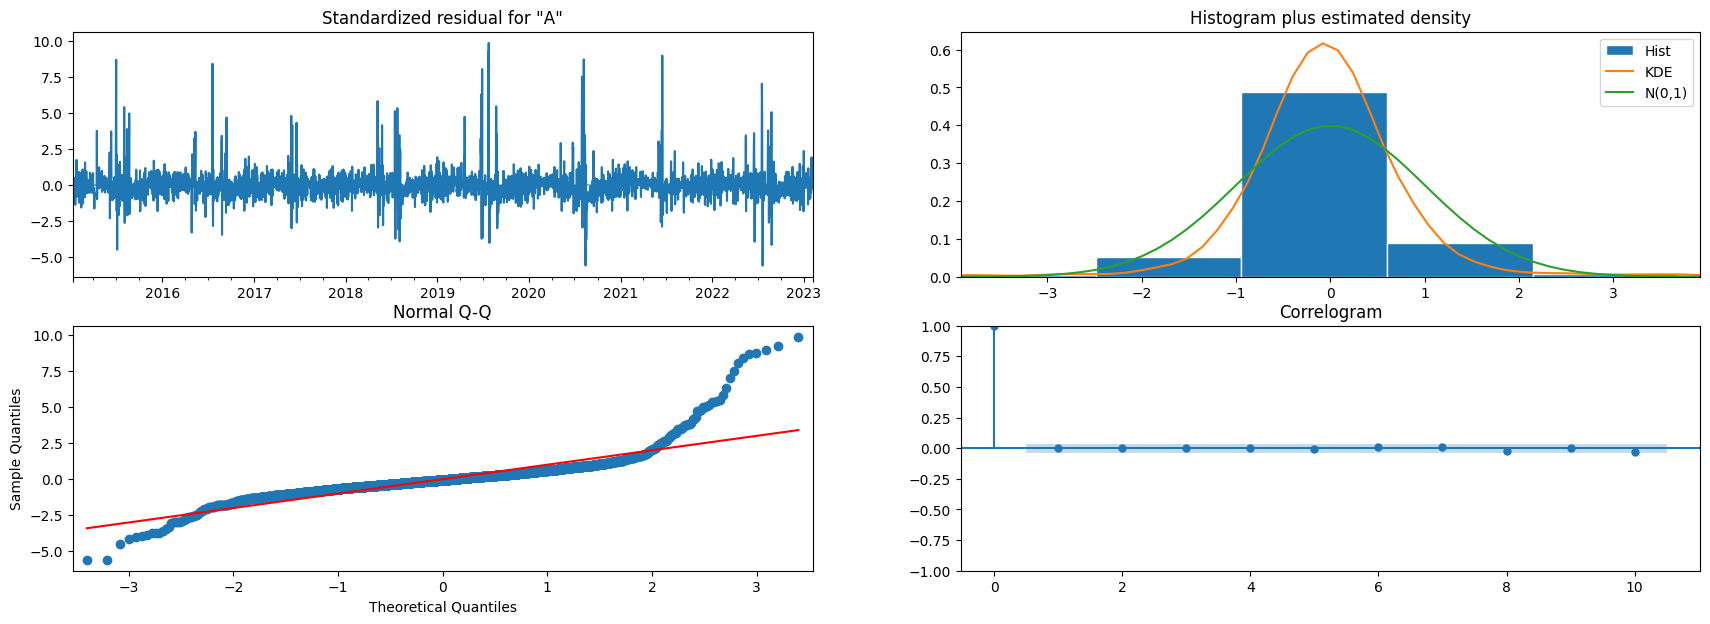

The KPSS test statistic 0.037027    pvalue: 0.10   maximal Lag: 1   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


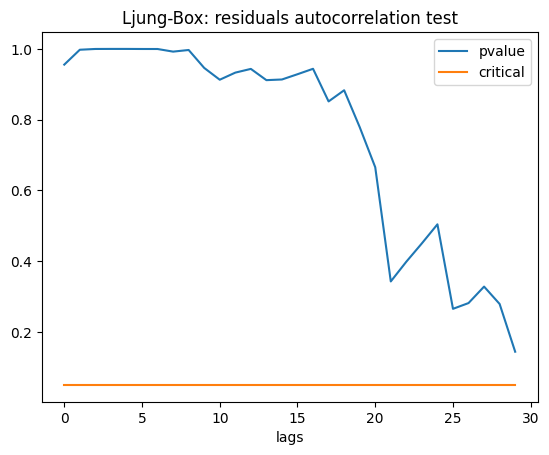

The Durbin-Watson residuals statistics 1.997162
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 1997192.000000, pvalue: 0.00
Wilcoxon: residuals are biased


In [278]:
StatTestWrapper.get_residuals_analysis(model_trend_no_season)

## SARIMAX exog_k1 (6,1,1)(0,0,0,0), exog = [Fourier for k=1], AUC = 22540

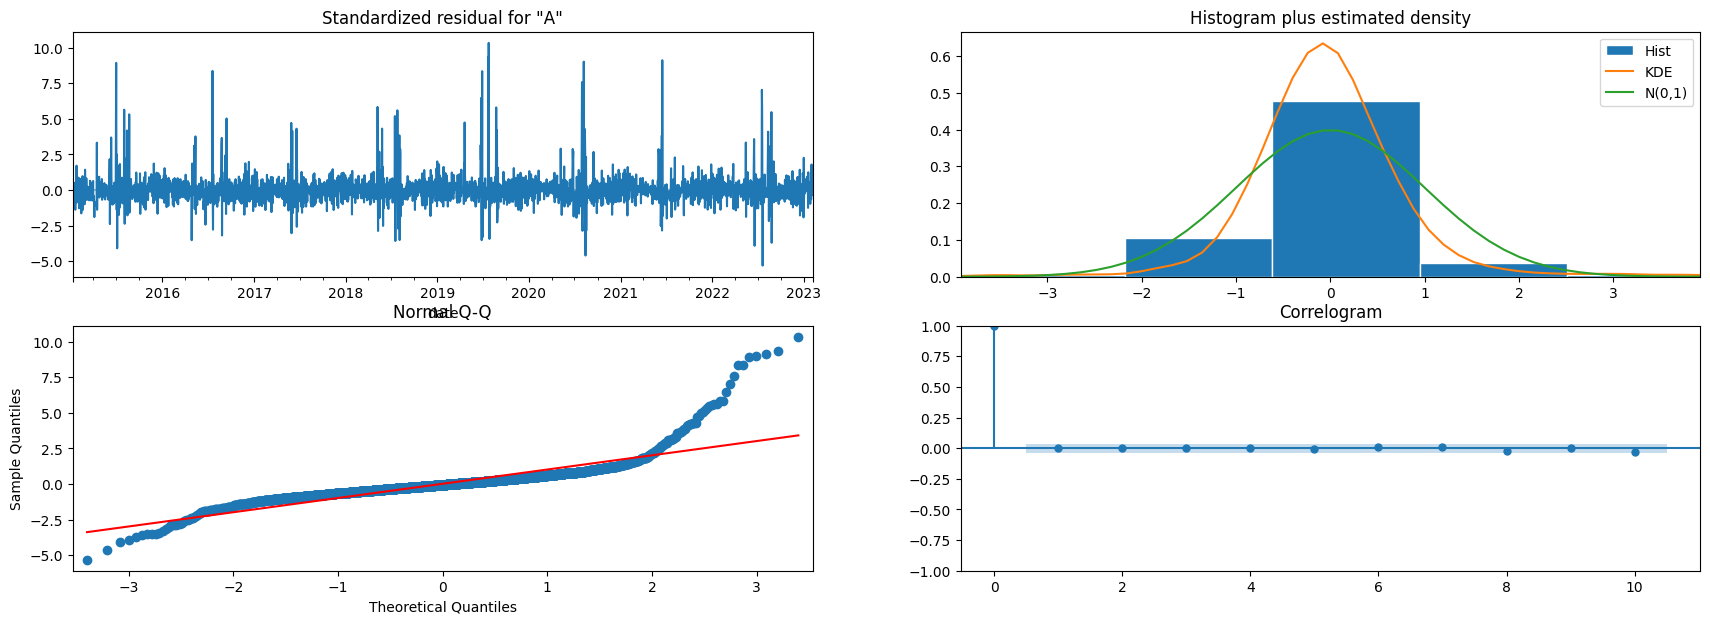

The KPSS test statistic 0.090971    pvalue: 0.10   maximal Lag: 1   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


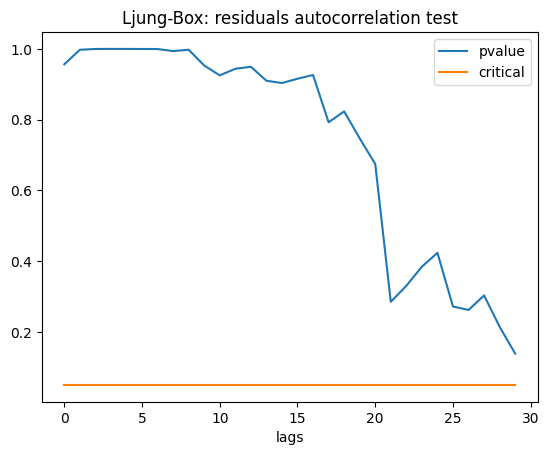

The Durbin-Watson residuals statistics 1.995138
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 1998932.000000, pvalue: 0.00
Wilcoxon: residuals are biased


In [279]:
StatTestWrapper.get_residuals_analysis(model_exog_k1)

## SARIMAX no_trend_season (2,0,2)(0, 1, 1, 12), exog = None, AUC = 22502

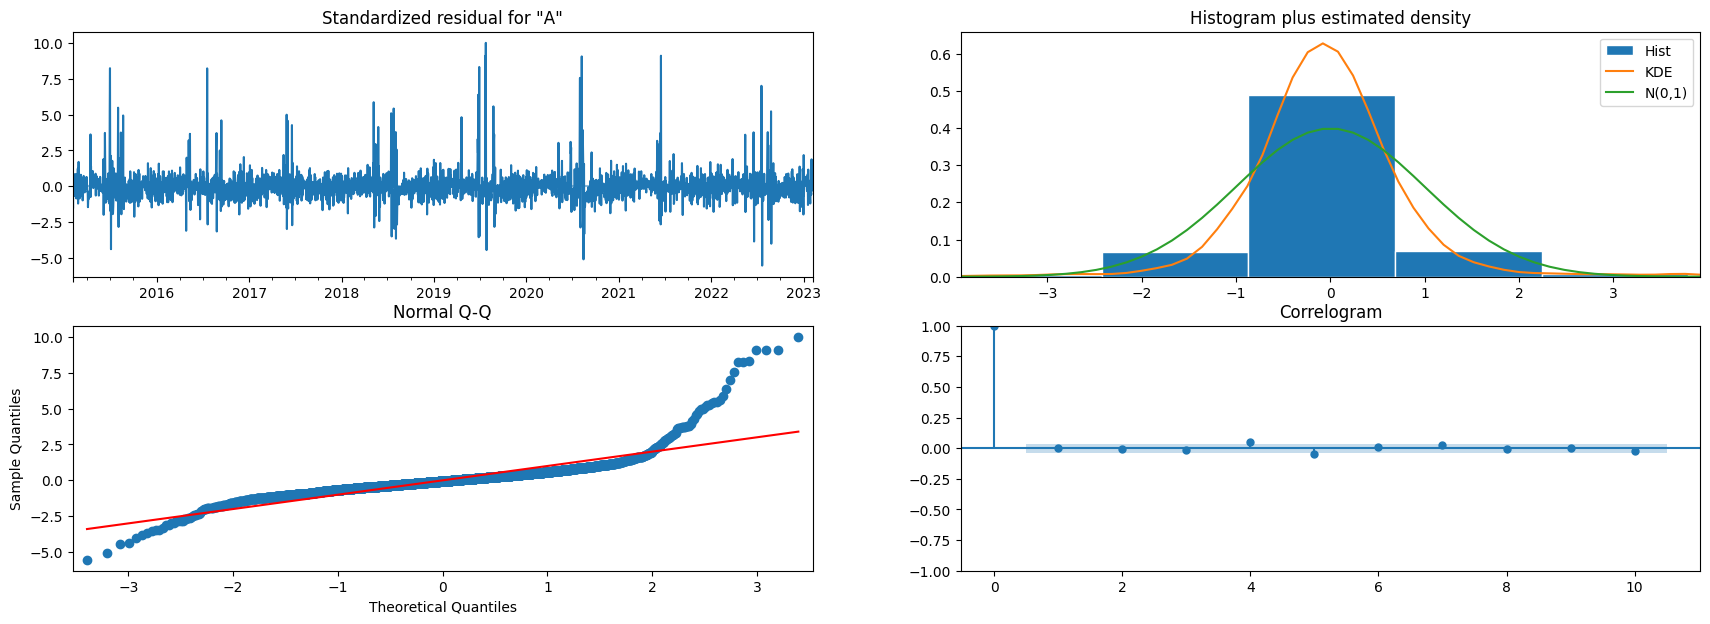

The KPSS test statistic 0.033662    pvalue: 0.10   maximal Lag: 6   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


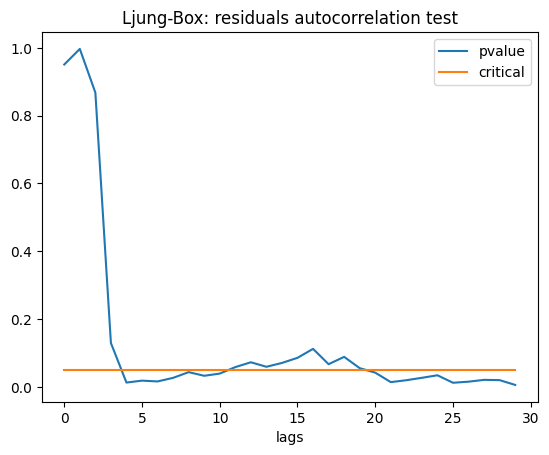

The Durbin-Watson residuals statistics 1.996954
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 1979375.000000, pvalue: 0.00
Wilcoxon: residuals are biased


In [280]:
StatTestWrapper.get_residuals_analysis(model_no_trend_season)

## SARIMAX trend_no_season_weather (6,1,1)(0,0,0,0), exog = [temperatures], AUC = 22114

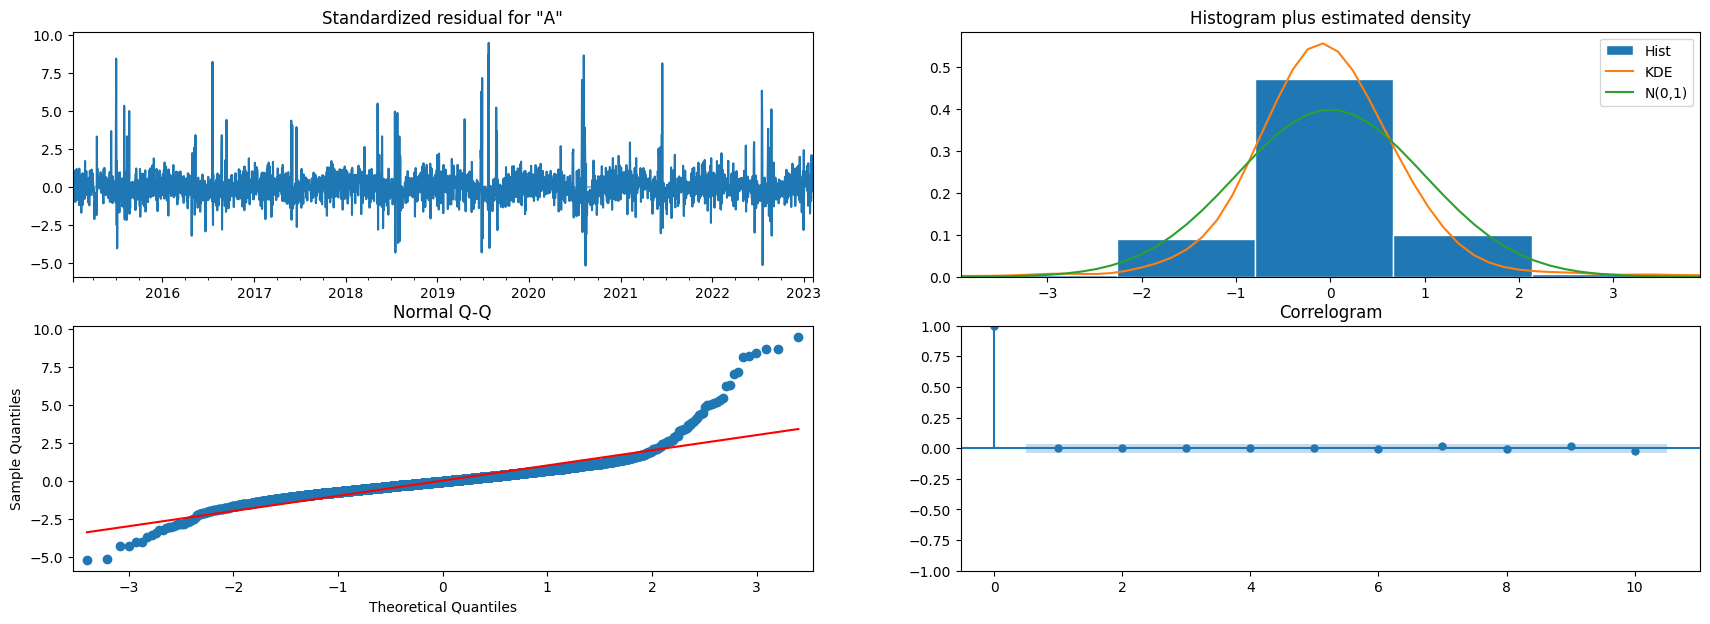

The KPSS test statistic 0.018555    pvalue: 0.10   maximal Lag: 0   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


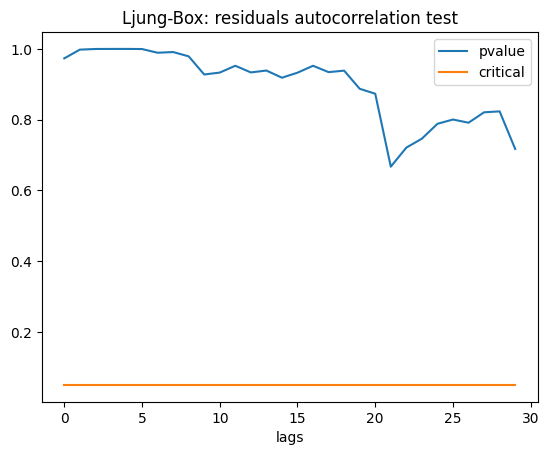

The Durbin-Watson residuals statistics 2.000991
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 2036637.000000, pvalue: 0.00
Wilcoxon: residuals are biased


In [281]:
StatTestWrapper.get_residuals_analysis(model_trend_no_season_weather)

## SARIMAX exog_k1_weather (6,1,1)(0,0,0,0), exog = [temperatures + Fourier k =1], AUC = 22049

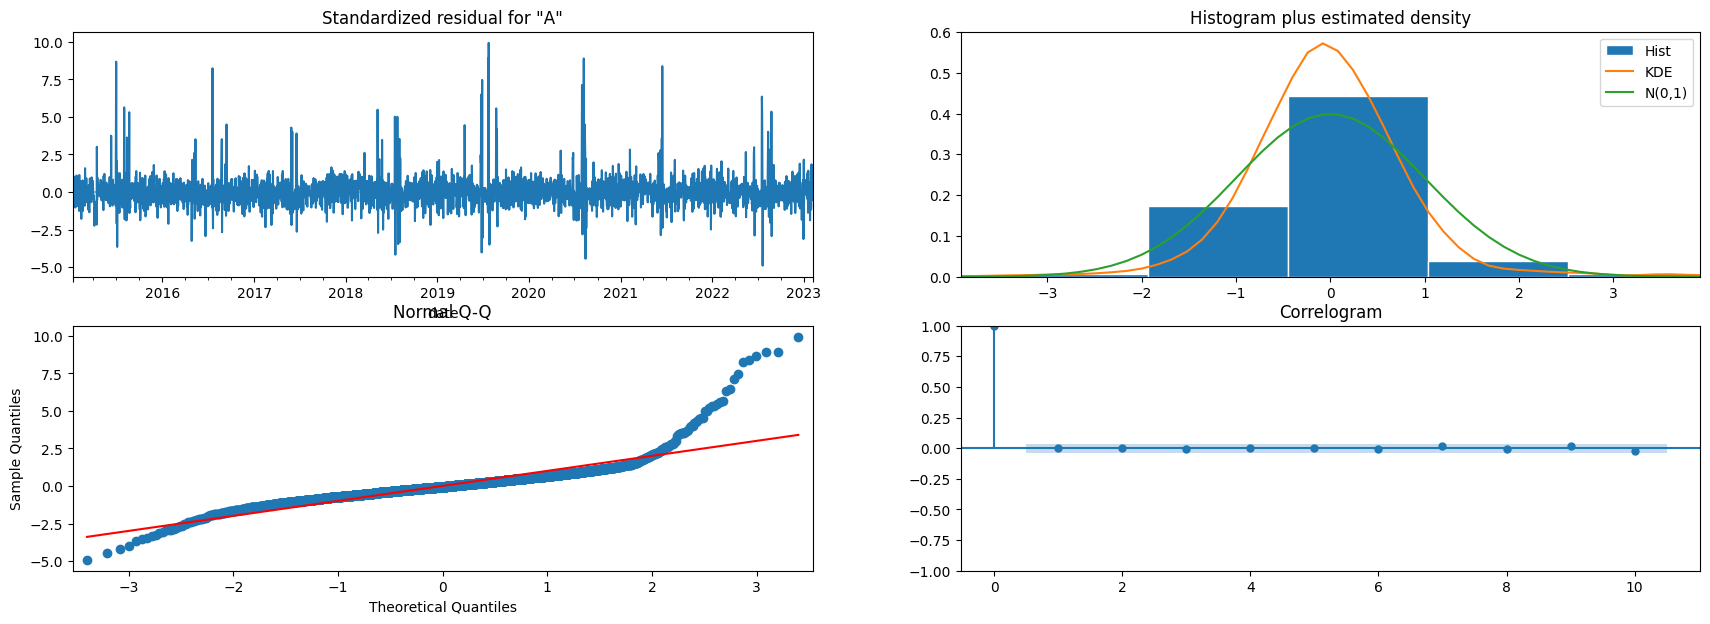

The KPSS test statistic 0.139256    pvalue: 0.10   maximal Lag: 0   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


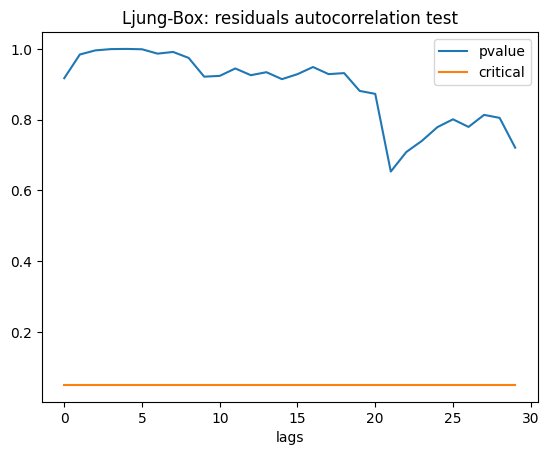

The Durbin-Watson residuals statistics 2.003471
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 2052219.000000, pvalue: 0.01
Wilcoxon: residuals are biased


In [132]:
StatTestWrapper.get_residuals_analysis(model_exog_k1_weather)

# Scores estimation

In [ ]:
#AUC 22636: model_trend_no_season = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1)).fit(disp=0)
#AUC 22540: model_exog_k1 = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_train).fit(disp=0)
#AUC 22502: model_no_trend_season = sm.tsa.statespace.SARIMAX(df_train, order=(2,0,2), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False).fit(disp=0)
#AUC 22114: model_trend_no_season_weather = sm.tsa.statespace.SARIMAX(df_train ,order=(6,1,1), exog=exog_weather_train).fit(disp=0)
#AUC 22049: model_exog_k1_weather = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_weather_train).fit(disp=0)

In [284]:
def cross_val_sarimax_calc_rmse(ts_train, order, seasonal_order, exog_train):
    tscv = TimeSeriesSplit(n_splits = 16)
    rmse = []
    all_predictions = None
    for train_index, test_index in tscv.split(ts_train):
        cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
        cv_exog_train, cv_exog_test = None, None
        if exog_train is not None:
            cv_exog_train, cv_exog_test = exog_train.iloc[train_index], exog_train.iloc[test_index]
        cv_model = sm.tsa.statespace.SARIMAX(cv_train, order=order, seasonal_order=seasonal_order, exog=cv_exog_train).fit(disp=0)
        predictions = cv_model.predict(start=cv_train.shape[0], end=cv_train.shape[0] + cv_test.shape[0] - 1, exog=cv_exog_test)
        if all_predictions is None:
            all_predictions = predictions
        else:
            all_predictions = pd.concat([all_predictions, predictions], axis=0)
        rmse.append(np.sqrt(mean_squared_error(cv_test.values, predictions)))
    rmse_mean = np.mean(rmse)
    return rmse_mean, all_predictions

In [151]:
def predict_sarimax_calc_rmse(ts_train, ts_val, order, seasonal_order, exog_train, exog_val):
    _model = sm.tsa.statespace.SARIMAX(ts_train, order=order, seasonal_order=seasonal_order, exog=exog_train).fit(disp=0)
    predictions = _model.predict(start=ts_train.shape[0], end=ts_train.shape[0] + ts_val.shape[0] - 1, exog=exog_val)
    rmse = np.sqrt(mean_squared_error(ts_val.values, predictions))
    return rmse, predictions

## SARIMAX trend_no_season (6,1,1)(0,0,0,0), exog = None, AUC = 22636

In [286]:
rmse_train_trend_no_season, train_predictions_trend_no_season = cross_val_sarimax_calc_rmse(ts_train=df_train, order=(6,1,1), seasonal_order=None, exog_train=None)
rmse_val_trend_no_season, predictions_trend_no_season = predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(6,1,1), seasonal_order=None, exog_train=None, exog_val=None)
rmse_train_trend_no_season, rmse_val_trend_no_season

(20.74206742998951, 9.852142367369781)

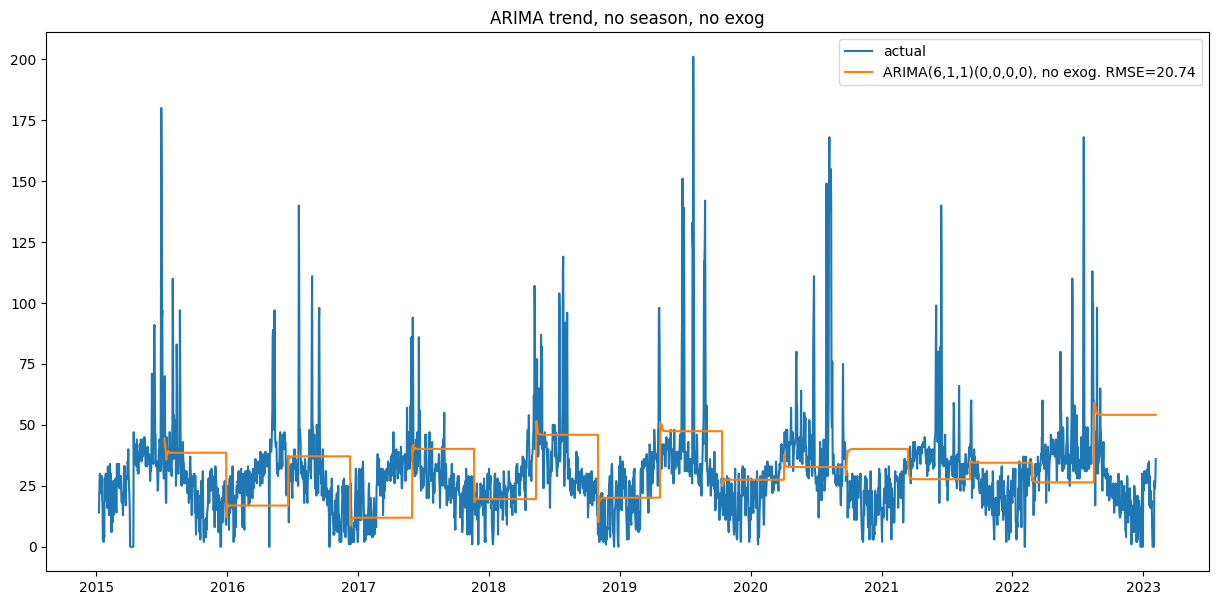

In [305]:
plt.figure(figsize=(15, 7))
plt.title("ARIMA trend, no season, no exog")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_trend_no_season, label="ARIMA(6,1,1)(0,0,0,0), no exog. RMSE=%.2f" % rmse_train_trend_no_season)
plt.legend()
plt.show()

## SARIMAX exog_k1 (6,1,1)(0,0,0,0), exog = [Fourier for k=1], AUC = 22540

In [287]:
rmse_train_exog_k1, train_predictions_exog_k1 = cross_val_sarimax_calc_rmse(ts_train=df_train, order=(6,1,1), seasonal_order=None, exog_train=exog_k1_train)
rmse_val_exog_k1, predictions_exog_k1 = predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(6,1,1), seasonal_order=None, exog_train=exog_k1_train, exog_val=exog_k1_val)
rmse_train_exog_k1, rmse_val_exog_k1

(14.204738405878377, 11.72517627045725)

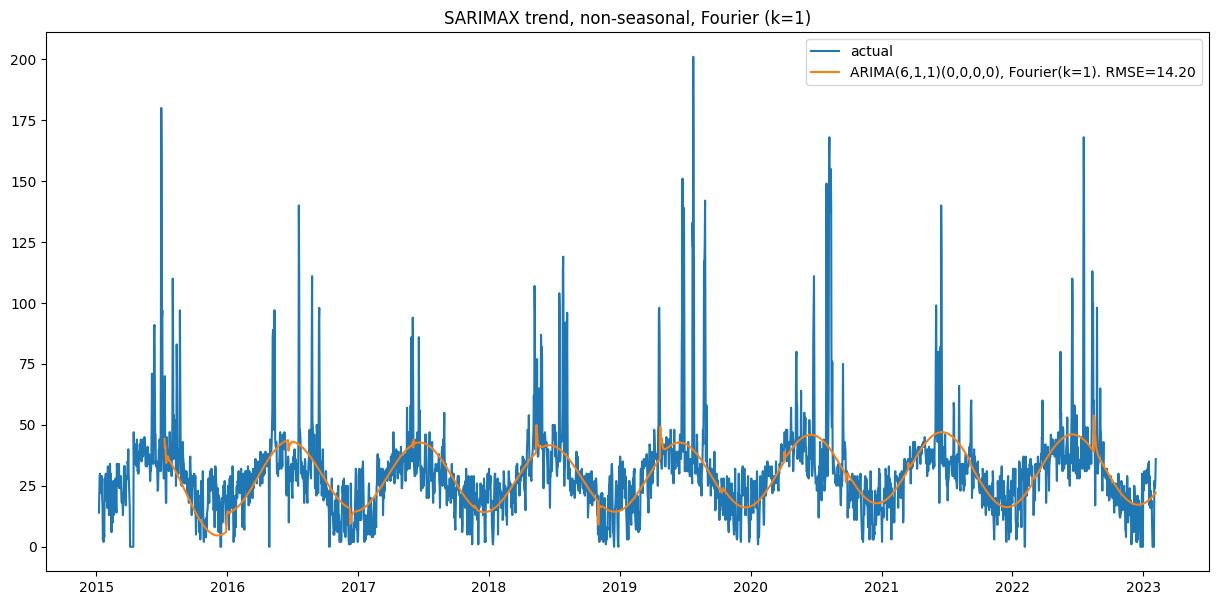

In [309]:
plt.figure(figsize=(15, 7))
plt.title("SARIMAX trend, non-seasonal, Fourier (k=1)")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_exog_k1, label="ARIMA(6,1,1)(0,0,0,0), Fourier(k=1). RMSE=%.2f" % rmse_train_exog_k1)
plt.legend()
plt.show()

## SARIMAX no_trend_season (2,0,2)(0,1,1,12), exog = None, AUC = 22502

In [288]:
rmse_train_no_trend_season, train_predictions_no_trend_season = cross_val_sarimax_calc_rmse(ts_train=df, order=(2,0,2), seasonal_order=(0,1,1,12), exog_train=None)
rmse_val_no_trend_season, predictions_no_trend_season = predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(2,0,2), seasonal_order=(0,1,1,12), exog_train=None, exog_val=None)
rmse_train_no_trend_season, rmse_val_no_trend_season

(18.563879098617335, 12.740009112445087)

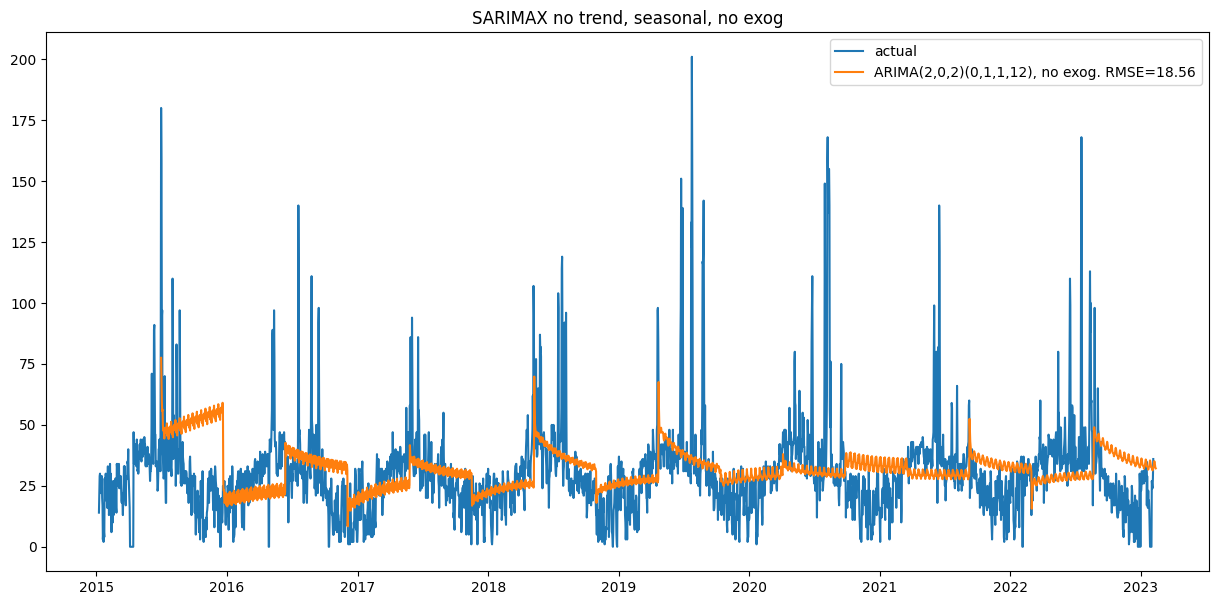

In [307]:
plt.figure(figsize=(15, 7))
plt.title("SARIMAX no trend, seasonal, no exog")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_no_trend_season, label="ARIMA(2,0,2)(0,1,1,12), no exog. RMSE=%.2f" % rmse_train_no_trend_season)
plt.legend()
plt.show()

## SARIMAX trend_no_season_weather (6,1,1)(0,0,0,0) exog = [temperatures], AUC = 22114

In [289]:
rmse_train_trend_no_season_weather, train_predictions_trend_no_season_weather = cross_val_sarimax_calc_rmse(ts_train=df_train, order=(6,1,1), seasonal_order=None, exog_train=exog_weather_train)
rmse_val_trend_no_season_weather, predictions_trend_no_season_weather = predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(6,1,1), seasonal_order=None, exog_train=exog_weather_train, exog_val=exog_weather_val)
rmse_train_trend_no_season_weather, rmse_val_trend_no_season_weather

(16.5261020677003, 5.774266788733205)

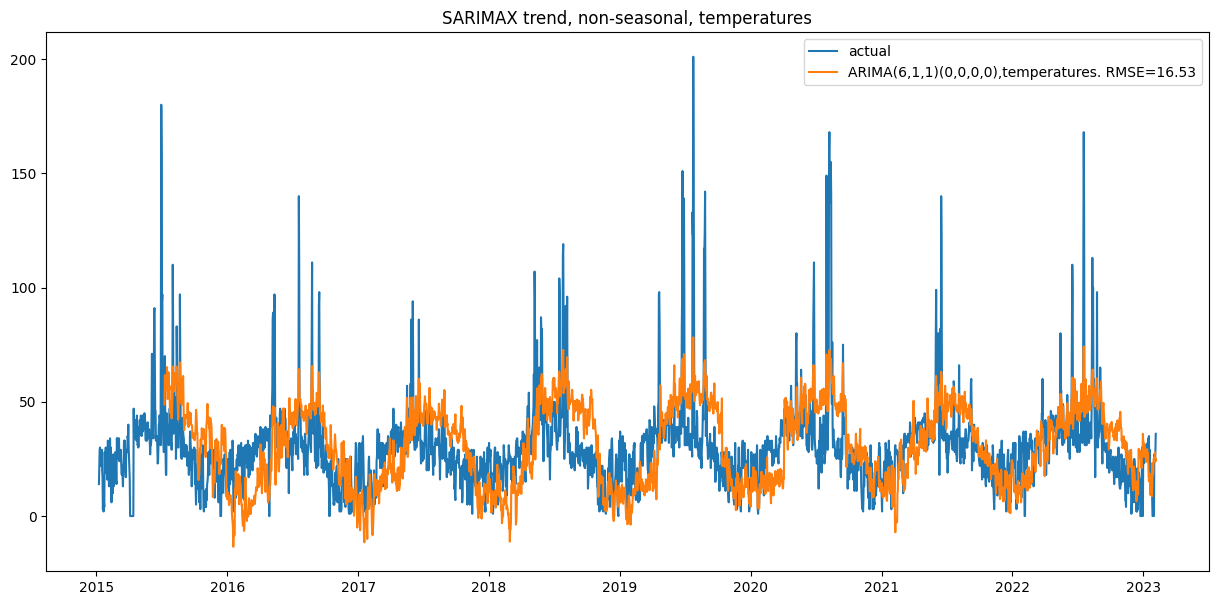

In [310]:
plt.figure(figsize=(15, 7))
plt.title("SARIMAX trend, non-seasonal, temperatures")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_trend_no_season_weather, label="ARIMA(6,1,1)(0,0,0,0),temperatures. RMSE=%.2f" % rmse_train_trend_no_season_weather)
plt.legend()
plt.show()

## SARIMAX exog_k1_weather (6,1,1)(0,0,0,0), exog = [temperatures + Fourier k =1], AUC = 22049

In [293]:
rmse_train_exog_k1_weather, train_predictions_exog_k1_weather = cross_val_sarimax_calc_rmse(ts_train=df_train, order=(6,1,1), seasonal_order=None, exog_train=exog_k1_weather_train)
rmse_val_exog_k1_weather, predictions_exog_k1_weather = predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(6,1,1), seasonal_order=None, exog_train=exog_k1_weather_train, exog_val=exog_k1_weather_val)
rmse_train_exog_k1_weather, rmse_val_exog_k1_weather

(13.654426529990698, 9.126616661788338)

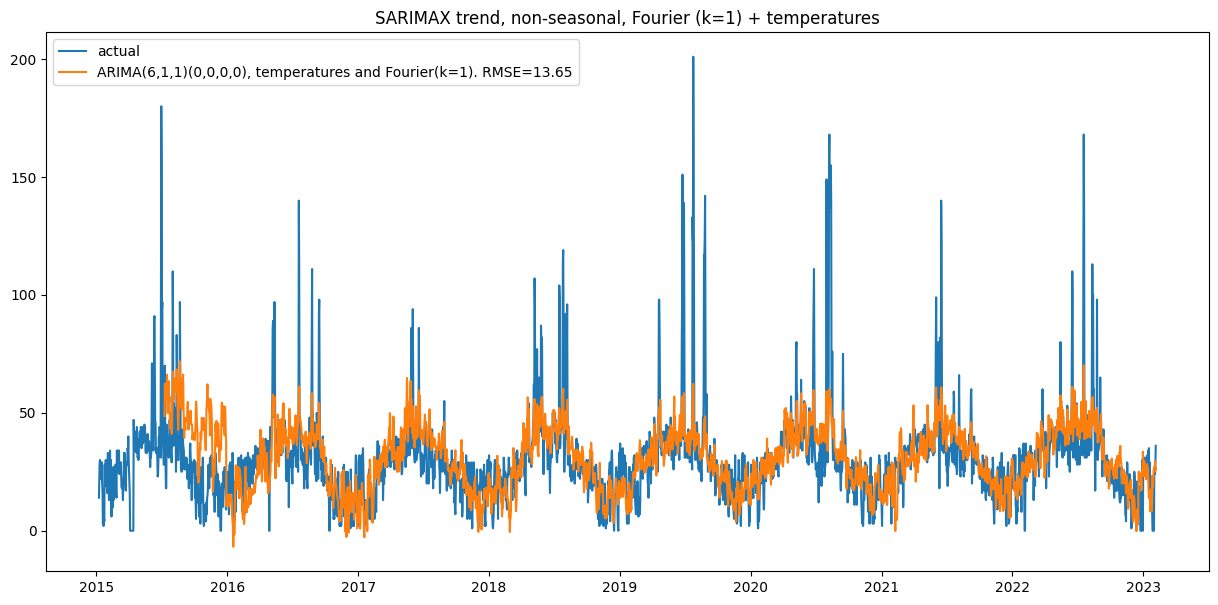

In [311]:
plt.figure(figsize=(15, 7))
plt.title("SARIMAX trend, non-seasonal, Fourier (k=1) + temperatures")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_exog_k1_weather, label="ARIMA(6,1,1)(0,0,0,0), temperatures and Fourier(k=1). RMSE=%.2f" % rmse_train_exog_k1_weather)
plt.legend()
plt.show()

# Baseline - Simple exponential smoothing

In [313]:
def ses_by_pols(alpha, y_train, y_val):
    ses = SimpleExpSmoothing(y_train)
    model_ses = ses.fit(smoothing_level = alpha, optimized = False)
    y_pred = model_ses.forecast(7)
    y_pred = [int(round(x)) for x in y_pred]
    score = np.sqrt(mean_squared_error(y_val.values, y_pred))
    return score, y_pred

In [329]:
alpha001 = 0.01
rmse_val_ses_a001, predictions_ses_a001_vals = ses_by_pols(alpha001, df_train, df_val)
rmse_val_ses_a001

10.810048235652923

In [330]:
alpha01 = 0.1
rmse_val_ses_a01, predictions_ses_a01_vals= ses_by_pols(alpha01, df_train, df_val)
rmse_val_ses_a01

7.681145747868608

In [327]:
alpha05 = 0.5
rmse_val_ses_a05, predictions_ses_a05_vals= ses_by_pols(alpha05, df_train, df_val)
rmse_val_ses_a05

15.883504471171161

In [326]:
alpha1 = 1
rmse_val_ses_a1, predictions_ses_a1_vals= ses_by_pols(alpha1, df_train, df_val)
rmse_val_ses_a1

21.44094880629786

In [332]:
predictions_ses_a01 = pd.DataFrame(index=df_val.index)
predictions_ses_a01[column_name] = rmse_val_ses_a01
predictions_ses_a01

,AQI_O3
DatetimeEnd,
2023-02-06,7.681146
2023-02-07,7.681146
2023-02-08,7.681146
2023-02-09,7.681146
2023-02-10,7.681146
2023-02-11,7.681146
2023-02-12,7.681146


# Forecast

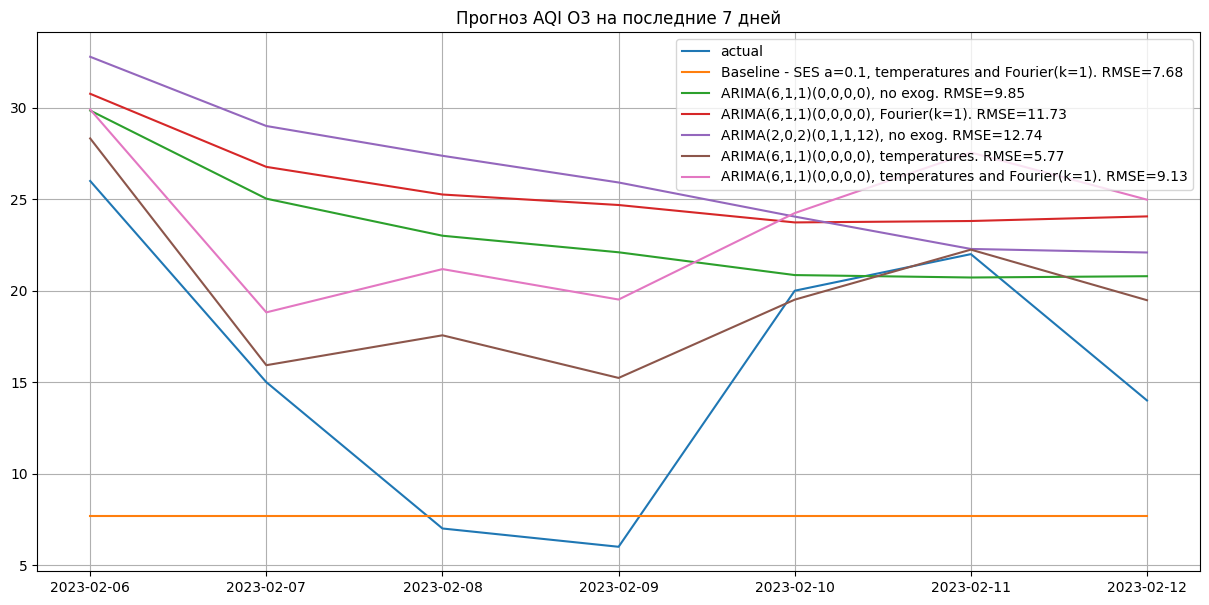

In [336]:
plt.figure(figsize=(15, 7))
plt.title(f"Прогноз AQI O3 на последние 7 дней")
plt.plot(df_val, label="actual")
plt.plot(predictions_ses_a01, label="Baseline - SES a=0.1, temperatures and Fourier(k=1). RMSE=%.2f" % rmse_val_ses_a01)
plt.plot(predictions_trend_no_season, label="ARIMA(6,1,1)(0,0,0,0), no exog. RMSE=%.2f" % rmse_val_trend_no_season)
plt.plot(predictions_exog_k1, label="ARIMA(6,1,1)(0,0,0,0), Fourier(k=1). RMSE=%.2f" % rmse_val_exog_k1)
plt.plot(predictions_no_trend_season, label="ARIMA(2,0,2)(0,1,1,12), no exog. RMSE=%.2f" % rmse_val_no_trend_season)
plt.plot(predictions_trend_no_season_weather, label="ARIMA(6,1,1)(0,0,0,0), temperatures. RMSE=%.2f" % rmse_val_trend_no_season_weather)
plt.plot(predictions_exog_k1_weather, label="ARIMA(6,1,1)(0,0,0,0), temperatures and Fourier(k=1). RMSE=%.2f" % rmse_val_exog_k1_weather)
plt.plot()
plt.legend()
plt.grid(True)
plt.show()